### 주차별 프로젝트(2주차 : 에어팟을 이용한 고장진단)
각 이미지 별로 고장을 진단
- 실질적인 고장 진단은 안되기에, 임의적인 클래스를 이용해서 고장났다고 가정을 한다.
    + for example,
    + 오른쪽 유닛이 없는 사진 ➡️ 오른쪽 유닛 고장
    + 왼쪽 유닛이 없는 사진 ➡️ 왼쪽 유닛 고장
    + 닫혀있는 사진 ➡️ 케이스 수리 요망
    + 두 유닛 다 있는 사진 ➡️ 정상
    + 두 유닛 다 없는 사진 ➡️ 모두 수리

Project Flow
- 이미지 수집
- CNN 모델 빌드
- 모델 평가
- 모델 최적화

### 필요 라이브러리 import

In [1]:
import cv2
import os
import numpy as np
import splitfolders
import pandas as pd
import winsound as wd
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from keras.models import Model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.applications import densenet
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping

### 이미지 수집
1회차
- 다이소 캠을 이용, 각도를 달리하고 물체의 일부분을 가려가면서 각 케이스별로 5장씩 수집(에어팟 케이스 x)

2회차
- 다이소 캠을 이용, 각도를 달리하고 물체의 일부분을 가려가면서 각 케이스별로 3장씩 수집(에어팟 케이스 x)

3회차
- 다이소 캠을 이용, 각도를 달리하고 물체의 일부분을 가려가면서 각 케이스별로 5장씩 수집(에어팟 케이스 o)

4회차
- 휴대폰으로 영상 촬영, 물체의 일부분을 가리는 과정 없이 각도만 달리하며 cv2로 캡쳐 후 사용. (에어팟 케이스 x) 각 각도별 5장

5회차
- 휴대폰으로 영상 촬영, 물체의 일부분을 가리는 과정 없이 각도만 달리하며 cv2로 캡쳐 후 사용. (에어팟 케이스 x) 각 각도별 2장
    + 4회차보다 세밀한 각도 조정
    + 정방형 촬영을 통한 물체 확대 촬영

In [2]:
vid_list = os.listdir("./video/")
for i, vid in enumerate(vid_list):
    cap = cv2.VideoCapture(f"./video/{vid}")
    save_main_dir = "./image2"
    class_list = ["closed", "left_missing", "missing_all", "opened", "right_missing"]

    for dir_name in class_list:
        if not os.path.isdir(f"{save_main_dir}/{dir_name}"):
            os.mkdir(f"{save_main_dir}/{dir_name}")

    file_cnt = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        key = cv2.waitKey(15)
        cv2.imshow("frame", frame)
        
        if key == ord(str(i+1)):
            cv2.imwrite(f"{save_main_dir}/{class_list[i]}/{file_cnt}.jpg", frame)
            file_cnt += 1
            
        if key == ord("q"):
            break

    cv2.destroyAllWindows()

### 클래스 별 이미지 개수 확인

In [3]:
for dir in os.listdir("./image/"):
    print(len(os.listdir(f"./image/{dir}")))

95
115
116
108
112


### 데이터셋 분할
train, test, val으로 분할

In [4]:
splitfolders.ratio("./image/", "./output2", seed = 1337, ratio = (.8, .1, .1))

Copying files: 546 files [00:00, 3418.70 files/s]


### 이미지 데이터 전처리
이미지 증강처리
- 별도의 추가 효과 없이 정규화만 진행

In [5]:
train_path = './output2/train/'
valid_path = './output2/val/'

train_generator = ImageDataGenerator(
    rescale = 1. / 255. ,
    # brightness_range = (0.5, 0.6),
    # width_shift_range = 0.2,
    # height_shift_range = 0.2, 
    # rotation_range = 7
    # zoom_range = 0.1
)

valid_generator = ImageDataGenerator(
    rescale = 1. / 255.
)

In [6]:
train_set = train_generator.flow_from_directory(
    train_path,
    target_size = (480, 640),
    color_mode = "rgb",
    batch_size = 4,
    class_mode = "categorical"
)

valid_set = valid_generator.flow_from_directory(
    valid_path,
    target_size = (480, 640),
    color_mode = "rgb",
    batch_size = 4,
    class_mode = "categorical"
)

Found 435 images belonging to 5 classes.


Found 52 images belonging to 5 classes.


### CNN 모델 빌드

In [7]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (480, 640, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation = "relu"))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation = "softmax"))
    
    return model
 
model = get_model()
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['acc'])

### Callback 함수 정의

In [8]:
if not os.path.isdir("./models"):
    os.mkdir("./models")
    os.mkdir("./models/history")

els = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
csv = CSVLogger("./models/history/training_history.csv")                            
check_point = ModelCheckpoint("./models/weights/{epoch:02d}-{val_loss:.2f}.hdf5", 
                              monitor = "val_loss",  
                              save_best_only = True, 
                              mode = "min"                                        
                            )
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, mode = "min", patience = 2)

callback_functions = [els, csv, check_point, reduce_lr]

### CNN모델 학습

In [9]:
model.fit(train_set, 
          steps_per_epoch = len(train_set), 
          epochs = 150, validation_data = valid_set, 
          validation_steps = len(valid_set),
          callbacks = callback_functions
        )

Epoch 1/150
109/109 [==============================] - 11s 68ms/step - loss: 4.5427 - acc: 0.2529 - val_loss: 1.5068 - val_acc: 0.3269 - lr: 0.0010
Epoch 2/150
109/109 [==============================] - 6s 55ms/step - loss: 1.0815 - acc: 0.6575 - val_loss: 1.2090 - val_acc: 0.6731 - lr: 0.0010
Epoch 3/150
109/109 [==============================] - 6s 54ms/step - loss: 0.2609 - acc: 0.9241 - val_loss: 1.0246 - val_acc: 0.7885 - lr: 0.0010
Epoch 4/150
109/109 [==============================] - 5s 45ms/step - loss: 0.0613 - acc: 0.9770 - val_loss: 1.5335 - val_acc: 0.7885 - lr: 0.0010
Epoch 5/150
109/109 [==============================] - 5s 45ms/step - loss: 0.0125 - acc: 1.0000 - val_loss: 1.6461 - val_acc: 0.7885 - lr: 0.0010
Epoch 6/150
109/109 [==============================] - 5s 45ms/step - loss: 0.0271 - acc: 0.9908 - val_loss: 1.5323 - val_acc: 0.7885 - lr: 3.0000e-04
Epoch 7/150
109/109 [==============================] - 5s 45ms/step - loss: 0.0129 - acc: 0.9977 - val_loss: 1.68

### CNN 모델 학습곡선 가시화

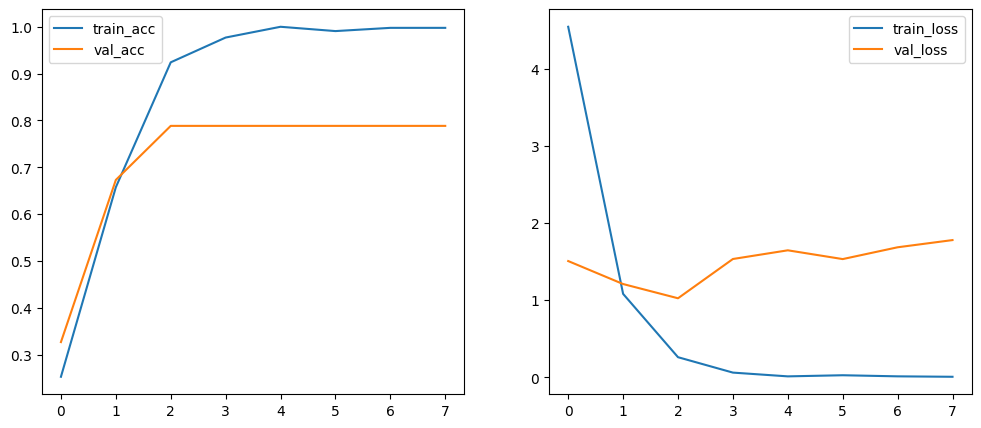

In [10]:
history = pd.read_csv("./models/history/training_history.csv")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['acc'], label = "train_acc")
plt.plot(history['epoch'], history['val_acc'], label = "val_acc")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['loss'], label = "train_loss")
plt.plot(history['epoch'], history['val_loss'], label = "val_loss")
plt.legend()

plt.show()

### 학습된 모델을 기반으로 예측
test 폴더에 있는 이미지들과 웹캠을 이용해 예측을 진행한다

In [11]:
# Test Directory First
class_list = {
    0 : "closed", 
    1 : "left_missing",
    2 : "missing_all", 
    3 : "opened",
    4 : "right_missing"
}

model = get_model()
model.load_weights("./models/weights/03-1.06.hdf5")

test_file_path = glob("./output2/test/*/*.jpg")
for i in range(10):
    test_image = cv2.imread(test_file_path[i])
    test_data = np.array(test_image)[:480, :640, :].reshape(1, 480, 640, 3)
    
    y_pred = model.predict(test_data, verbose = 0)
    y_true = test_file_path[i]
    print("="*30)
    print(y_true)
    print(class_list[np.argmax(y_pred)])

./output2/test\closed\28.jpg
closed
./output2/test\closed\47.jpg
closed
./output2/test\closed\50.jpg
closed
./output2/test\closed\53.jpg
missing_all
./output2/test\closed\70.jpg
missing_all
./output2/test\closed\75.jpg
opened
./output2/test\closed\76.jpg
opened
./output2/test\closed\80.jpg
closed
./output2/test\closed\82.jpg
closed
./output2/test\closed\90.jpg
closed


In [12]:
model = get_model()
model.load_weights("./models/weights/03-1.06.hdf5")

def get_result(frame, model):
    test_images_path = "./model_testing"
    cv2.imwrite(f"{test_images_path}/my_test.jpg", frame)
    img = cv2.imread(f"{test_images_path}/my_test.jpg")
    test_data = np.array(test_image)[:480, :640, :].reshape(1, 480, 640, 3)
    
    y_pred = model.predict(test_data, verbose = 0)
    result = class_list[np.argmax(y_pred)]
    
    return result

In [13]:
cap = cv2.VideoCapture(0)
while True:
    res, frame = cap.read()
    
    if not res:
        break
    
    key = cv2.waitKey(1)
    result = get_result(frame, model)
    
    font = cv2.FONT_HERSHEY_PLAIN
    green = (255, 0, 0)
    
    img = cv2.putText(frame, result, (350, 40), font, 2, green, 1, cv2.LINE_AA)
    cv2.imshow("RESULTS", img)
    
    if result == "there's no any units":
        wd.Beep(500, 1000)
    
    if key == ord('q'):
        break
    
cv2.destroyAllWindows()

### 전이학습 모델 빌드
- Densenet을 활용, 전이학습 모델 빌드

### Why Densenet?
DenseNet의 핵심 아이디어는 **"Feed Forward시 각 layer들이 다른 모든 layer들과 연결을 한다."** 라는 점에 있다. DenseNet의 논문을 참고하면 이런 핵심 아이디어로 부터 얻을 수 있는 4가지의 장점을 주장한다.

- 기울기 소실 문제를 완화할 수 있다.
- Feature Propagation을 강화할 수 있다.
- Feature의 재사용이 가능하다.
- parameter의 수를 줄일 수 있다.

수많은 layer의 연결로 이뤄진 모델이기에 위의 세 가지 장점은 이해가 된다만, parameter의 수는 오히려 증가하지 않는가 하는 의문도 든다. 어떻게 줄어드는걸까?

DenseNet의 실제 연결 과정을 보면 아래와 같다.
<div align=center><img src="../image/DenseNet.png"></div>

왼쪽은 ResNet모델의 연결과정으로, Feature들을 채널축으로 그냥 더해준다. 반면에 오른쪽의 DenseNet연결 방식은 Feature들을 채널축으로 concatenation을 통해서 연결시켜준다.

이렇게 발생하는 차이점은 DenseNet은 output Feature의 channel이 더 커진다는 것인데, 이를 위해서 DenseNet의 한 layer의 output의 channel의 크기를 제한하는데, 이를 `Growth Rate`라고 한다. 이 GrowthRate가 하는 역할은 아래와 같다.
- Feature를 concat하는 DenseNet의 특성상 연산량이 많아질 수 밖에 없다.
- 이 때 GrowthRate:k는 각 layer에서 몇 개의 Feature map이 생성될지를 조절하는 역할을 한다.

In [14]:
def get_pretrained_model():
    my_params = {
        'weights' : 'imagenet',
        'include_top' : False,
        'pooling' : 'max',
        'classes' : 5,
        'classifier_activation' : 'softmax',
        'input_shape' : (480, 640, 3)
    }

    pred_model = densenet.DenseNet201(**my_params)
    
    for layer in pred_model.layers: 
        layer.trainable = False

    pre_input_layer = pred_model.input
    pre_output_layer = pred_model.output
    x = Dense(64, activation = "relu")(pre_output_layer)
    x = Dropout(0.3)(x)
    x = Dense(5, activation = "softmax")(x)

    pretrained_model = Model(pre_input_layer, x)
    optim = Adam(0.001)
    pretrained_model.compile(optimizer = optim, loss = "categorical_crossentropy", metrics = ['acc'])
    
    return pretrained_model

### 전이학습 전용 데이터셋 생성

In [15]:
pre_train_generator = ImageDataGenerator(
    rescale = 1./255. ,
)

pretrained_train_set = pre_train_generator.flow_from_directory(
    train_path,
    target_size = (480, 640),
    color_mode = "rgb",
    batch_size = 4,
    class_mode = "categorical"
)

pretrained_valid_set = valid_generator.flow_from_directory(
    valid_path,
    target_size = (480, 640),
    color_mode = "rgb",
    batch_size = 4,
    class_mode = "categorical"
)

Found 435 images belonging to 5 classes.
Found 52 images belonging to 5 classes.


### 전이학습용 Call back 함수 정의

In [16]:
pre_els = EarlyStopping(monitor = "val_loss", mode = "min", patience = 5)
pre_csv = CSVLogger("./models/densenet/history/training_history.csv")
pre_check_point = ModelCheckpoint("./models/densenet/weights/{epoch:02d}-{val_loss:.2f}.hdf5", 
                              monitor = "val_loss", 
                              save_best_only = True,
                              mode = "min"
                              )
pre_reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.3, mode = "min", patience = 2)
pre_callback_functions = [pre_csv, pre_check_point, pre_reduce_lr, pre_els]

### 전이학습 모델 훈련

In [17]:
if not os.path.isdir("./models/densenet"):
    os.mkdir("./models/densenet")
    os.mkdir("./models/densenet/history")

pretrained_model = get_pretrained_model()
pretrained_model.fit(pretrained_train_set, 
                    steps_per_epoch = len(pretrained_train_set), 
                    epochs = 150, validation_data = pretrained_valid_set, 
                    validation_steps = len(pretrained_valid_set),
                    callbacks = pre_callback_functions
                )

Epoch 1/150
109/109 [==============================] - 20s 129ms/step - loss: 1.8036 - acc: 0.3793 - val_loss: 0.9281 - val_acc: 0.5385 - lr: 0.0010
Epoch 2/150
109/109 [==============================] - 12s 107ms/step - loss: 0.9451 - acc: 0.5747 - val_loss: 0.7389 - val_acc: 0.7500 - lr: 0.0010
Epoch 3/150
109/109 [==============================] - 12s 107ms/step - loss: 0.7916 - acc: 0.6506 - val_loss: 0.5717 - val_acc: 0.7885 - lr: 0.0010
Epoch 4/150
109/109 [==============================] - 12s 107ms/step - loss: 0.7107 - acc: 0.6644 - val_loss: 0.4920 - val_acc: 0.8846 - lr: 0.0010
Epoch 5/150
109/109 [==============================] - 12s 107ms/step - loss: 0.6272 - acc: 0.7149 - val_loss: 0.4057 - val_acc: 0.8846 - lr: 0.0010
Epoch 6/150
109/109 [==============================] - 12s 107ms/step - loss: 0.6114 - acc: 0.7310 - val_loss: 0.3356 - val_acc: 0.9615 - lr: 0.0010
Epoch 7/150
109/109 [==============================] - 11s 101ms/step - loss: 0.5394 - acc: 0.7632 - val_l

### 전이학습 학습곡선 가시화

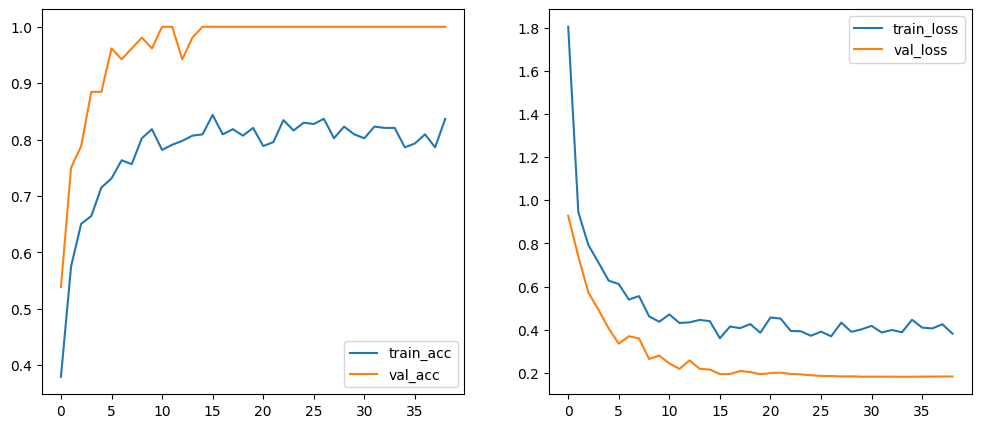

In [18]:
history = pd.read_csv("./models/densenet/history/training_history.csv")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['acc'], label = "train_acc")
plt.plot(history['epoch'], history['val_acc'], label = "val_acc")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['loss'], label = "train_loss")
plt.plot(history['epoch'], history['val_loss'], label = "val_loss")
plt.legend()

plt.show()

### 모델 예측(Test Directory & Capture from Camera)


In [19]:
# Test Directory First
class_list = {
    0 : "closed", 
    1 : "left_missing",
    2 : "missing_all", 
    3 : "opened",
    4 : "right_missing"
}

pretrained_model = get_pretrained_model()
pretrained_model.load_weights("./models/densenet/weights/28-0.10.hdf5")

test_file_path = glob("./output2/test/*/*.jpg")
for i in range(10):
    test_image = cv2.imread(test_file_path[i])
    test_data = np.array(test_image)[:480, :640, :].reshape(1, 480, 640, 3)
    
    y_pred = pretrained_model.predict(test_data, verbose = 0)
    y_true = test_file_path[i]
    print(y_true)
    print(class_list[np.argmax(y_pred)])

./output2/test\closed\28.jpg
missing_all
./output2/test\closed\47.jpg
missing_all
./output2/test\closed\50.jpg
closed
./output2/test\closed\53.jpg
missing_all
./output2/test\closed\70.jpg
missing_all
./output2/test\closed\75.jpg
missing_all
./output2/test\closed\76.jpg
missing_all
./output2/test\closed\80.jpg
missing_all
./output2/test\closed\82.jpg
closed
./output2/test\closed\90.jpg
closed


In [20]:
def get_result(frame, model):
    
    test_images_path = "./model_testing"
    cv2.imwrite(f"{test_images_path}/my_test.jpg", frame)
    img = cv2.imread(f"{test_images_path}/my_test.jpg")
    test_data = np.array(img)[:480, :640, :].reshape(1, 480, 640, 3)
    
    y_pred = model.predict(test_data, verbose = 0)
    result = class_list[np.argmax(y_pred)]
    
    return result

In [21]:
# if not os.path.isdir("./model_testing"):
#     os.mkdir('./model_testing')

pretrained_model = get_pretrained_model()
pretrained_model.load_weights("./models/densenet/weights/28-0.10.hdf5")

cap = cv2.VideoCapture(0)
cap.set(3, 1280)
cap.set(4, 960)
while True:
    res, frame = cap.read()
    
    if not res:
        break
    
    key = cv2.waitKey(1)
    result = get_result(frame, pretrained_model)
    
    font = cv2.FONT_HERSHEY_PLAIN
    green = (255, 0, 0)
    
    img = cv2.putText(frame, result, (350, 40), font, 2, green, 1, cv2.LINE_AA)
    cv2.imshow("RESULTS", img)
    
    # if result == "there's no any units":
    #     wd.Beep(500, 1000)
    
    if key == ord('q'):
        break
    
cv2.destroyAllWindows()